# 불법 현수막 탐지 프로젝트 Main

### <시나리오>

* 촬영 데이터 입력
* Yolov8 현수막 추출
* OCR 텍스트 추출
* chatGPT 대분류
* Dataframe에 기록

##### 1) 마을버스/순찰차/순찰 시 GPS 기준 이동거리 5m 간격 촬영

In [206]:
import json

# 촬영된 데이터 format 예시
# 16개의 사진 데이터 
json_file_path = 'capture_data/meta_data.json'

with open(json_file_path, 'r') as json_file:
    meta_data = json.load(json_file)

# 카메라 촬영을 통해 필요한 데이터 요소
# id(고유키), filename(파일명), timestamp(날짜/시간), location(위도/경도)
meta_data

{'dataset_info': {'name': '불법 현수막 탐지 프로젝트 데이터셋',
  'version': '1.0',
  'description': '도로에서 촬영한 불법 현수막 탐지 데이터셋',
  'date_created': '2023-08-12T15:00:00.123456'},
 'data': [{'id': 1,
   'file_name': 'data_001.jpg',
   'timestamp': '2023-08-12T15:00:00.123456',
   'location': {'latitude': 37.123456, 'longitude': -122.789012}},
  {'id': 2,
   'file_name': 'data_002.jpg',
   'timestamp': '2023-08-12T15:05:00.123456',
   'location': {'latitude': 37.123501, 'longitude': -122.789012}},
  {'id': 3,
   'file_name': 'data_003.jpg',
   'timestamp': '2023-08-12T15:10:00.123456',
   'location': {'latitude': 37.123546, 'longitude': -122.789012}},
  {'id': 4,
   'file_name': 'data_004.jpg',
   'timestamp': '2023-08-12T15:15:00.123456',
   'location': {'latitude': 37.123591, 'longitude': -122.789012}},
  {'id': 5,
   'file_name': 'data_005.jpg',
   'timestamp': '2023-08-12T15:20:00.123456',
   'location': {'latitude': 37.123636, 'longitude': -122.789012}},
  {'id': 6,
   'file_name': 'data_006.jpg',
 

##### 2) yolov8 활용 데이터별(id별) 현수막 crop

In [207]:
# 학습한 모델 load

# https://stackoverflow.com/questions/24773109/how-to-downgrade-the-installed-version-of-pip-on-windows
# pip install torchvision==0.15.1
from ultralytics import YOLO
import torch
from datetime import datetime
import shutil
import os
from glob import glob
import time

# cpu
# device = 'cpu'

# gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

model = YOLO('models/08_13_banner576_best.pt')
model

cuda


In [208]:
imgs = glob('capture_data/*.jpg')
imgs

['capture_data\\data_001.jpg',
 'capture_data\\data_002.jpg',
 'capture_data\\data_003.jpg',
 'capture_data\\data_004.jpg',
 'capture_data\\data_005.jpg',
 'capture_data\\data_006.jpg',
 'capture_data\\data_007.jpg',
 'capture_data\\data_008.jpg',
 'capture_data\\data_009.jpg',
 'capture_data\\data_010.jpg',
 'capture_data\\data_011.jpg',
 'capture_data\\data_012.jpg',
 'capture_data\\data_013.jpg',
 'capture_data\\data_014.jpg',
 'capture_data\\data_015.jpg',
 'capture_data\\data_016.jpg']

In [209]:
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm

# DataFrame 정의

# <Columns>  
# Id(고유 키)
# Date(날짜) 
# Time(시간) 
# Location(위치) 
# Origin_img(원본사진) 
# Crop_imgs(detect된 사진들) 
# OCR_text(추출 텍스트)
# Category(현수막 종류) 
# Legality(합/불법)  


print(" meta data 요소 : ",meta_data['data'][0].keys())

df_data = []
for item in tqdm(meta_data['data']):

    date_time = item['timestamp'].split("T")
    df_row = {
        'ID' : item['id'],
        'Date' : date_time[0],
        'Time' : date_time[1],
        'Location' : [item['location']['latitude'], item['location']['longitude']],
        'Origin_img' : np.array(Image.open('capture_data/'+item['file_name'])),
        'Detect_img' : [],
        'Crop_classes' : [],
        'Crop_imgs' : [],
        'Crop_xyxy' : [], # 좌표 시작점 x,y / 끝점 x,y
        'Crop_conf': [],
        'OCR_text' : [],
        'Category' : [],
        'Legality' : []
    }

    df_data.append(df_row)

df_report = pd.DataFrame(df_data)

# date_created : 데이터 수집한 날짜
date_created = meta_data['dataset_info']['date_created'].split("T")[0].split("-")
df_report.to_csv('reports/report_'+'_'.join(date_created)+'.csv')
df_report

 meta data 요소 :  dict_keys(['id', 'file_name', 'timestamp', 'location'])


100%|██████████| 16/16 [00:00<00:00, 145.45it/s]


,ID,Date,Time,Location,Origin_img,Detect_img,Crop_classes,Crop_imgs,Crop_xyxy,Crop_conf,OCR_text,Category,Legality
0,1,2023-08-12,15:00:00.123456,"[37.123456, -122.789012]","[[[76, 104, 105], [74, 102, 103], [84, 112, 11...",[],[],[],[],[],[],[],[]
1,2,2023-08-12,15:05:00.123456,"[37.123501, -122.789012]","[[[38, 37, 35], [46, 45, 43], [73, 73, 71], [8...",[],[],[],[],[],[],[],[]
2,3,2023-08-12,15:10:00.123456,"[37.123546, -122.789012]","[[[21, 44, 24], [5, 28, 8], [9, 31, 10], [14, ...",[],[],[],[],[],[],[],[]
3,4,2023-08-12,15:15:00.123456,"[37.123591, -122.789012]","[[[60, 102, 127], [101, 143, 168], [111, 153, ...",[],[],[],[],[],[],[],[]
4,5,2023-08-12,15:20:00.123456,"[37.123636, -122.789012]","[[[175, 205, 205], [169, 191, 188], [79, 92, 8...",[],[],[],[],[],[],[],[]
5,6,2023-08-12,15:25:00.123456,"[37.123681, -122.789012]","[[[95, 107, 93], [101, 111, 100], [108, 118, 1...",[],[],[],[],[],[],[],[]
6,7,2023-08-12,15:30:00.123456,"[37.123726, -122.789012]","[[[113, 113, 105], [97, 97, 89], [86, 86, 78],...",[],[],[],[],[],[],[],[]
7,8,2023-08-12,15:35:00.123456,"[37.123771, -122.789012]","[[[26, 31, 37], [28, 33, 39], [32, 37, 41], [4...",[],[],[],[],[],[],[],[]
8,9,2023-08-12,15:40:00.123456,"[37.123816, -122.789012]","[[[251, 248, 243], [249, 248, 243], [248, 251,...",[],[],[],[],[],[],[],[]
9,10,2023-08-12,15:45:00.123456,"[37.123861, -122.789012]","[[[123, 159, 89], [109, 144, 80], [175, 208, 1...",[],[],[],[],[],[],[],[]


In [224]:
class_names = ['banner','frame']
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif']

predict_path = 'runs/detect/predict/'
predict_detect_path = predict_path
predict_crop_banner_path = predict_path+class_names[0]
predict_crop_frame_path = predict_path+class_names[1]

log_path = 'logs/'

In [211]:
def move_all_img(source_folder, destination_folder):
    # source_folder 내의 모든 항목을 destination_folder로 이동
    for item in os.listdir(source_folder):
        source_item = os.path.join(source_folder, item)
        destination_item = os.path.join(destination_folder, item)
        shutil.move(source_item, destination_item)

In [212]:
def move_img(source_path, destination_path):
    if not os.path.exists(os.path.dirname('/'.join(destination_path.split('/')[:-1])+'/')):
        os.makedirs(os.path.dirname('/'.join(destination_path.split('/')[:-1])+'/'))
    
    # 파일 이동
    shutil.move(source_path, destination_path)

In [213]:
def yolo_run(img):

    # GPU predict 시, show=False/save=True로 설정 
    results = model.predict(
                            source=img, # 디렉토리 (capture_data/)
                            conf=0.5, # confidence threshold for detection (오탐지 시 재설정)
                            save=True,  # Detect 결과 저장 (runs/detect/predict)
                            device=device, # device 설정
                            show=False, # window 창으로 show
                            save_crop=True # Detect된 Obeject 사진 저장 (runs/detect/predict/crops)
                            )
    
    image = np.array(Image.open(img))
    # print("image : ",image)
    # print("image.shape : ",image.shape)

    for idx,result in enumerate(results):
        now = datetime.now()
        now_time = str(now.year) + str(now.month) + str(now.day) + '_' + str(now.hour) + str(now.minute) + str(now.second)

        boxes = result.boxes
        saved_img = ''

        print("================================= Predict 결과 =================================")

        file_name = img.split('\\')[-1]
        img_name = file_name[:-4]
        # ext_name = file_name[-4:]

        ### 데이터 logs에 저장
        # 데이터이름+날짜시간
        data_datetime_dir = log_path+now_time+'_'+img_name+'/'
        # predict된 결과를 'logs/'에 저장
        move_all_img(predict_path,data_datetime_dir)
        # 원본 이미지 저장
        os.makedirs(data_datetime_dir+'origin_img/')
        shutil.copyfile(img,data_datetime_dir+'origin_img/'+img.split('\\')[-1])
        # detect된 이미지 저장
        move_img(data_datetime_dir+file_name,data_datetime_dir+'detect_img/'+file_name)
        # crop_imgs로 폴더명 변경
        os.rename(data_datetime_dir+'crops', data_datetime_dir+'crop_imgs')

        ### 데이터 df에 저장
        # ID 값
        id = int(img_name.split('_')[-1])-1
        # detect_img 기록
        df_report['Detect_img'].iloc[id] = np.array(Image.open(data_datetime_dir+'detect_img/'+file_name))

        crop_classes = []
        crop_imgs = []
        crop_xyxy = []
        crop_conf = []
        for idx,box in enumerate(boxes):
            # crop된 object 이름 기록
            crop_classes.append(class_names[int(box.cls)])
            # crop된 xyxy 좌표 기록
            xyxy = list(box.xyxy[0].to('cpu').numpy().astype('int'))
            x_min, y_min, x_max, y_max = xyxy
            crop_xyxy.append([x_min, y_min, x_max, y_max])
            # crop된 이미지 기록
            crop_imgs.append(image[y_min:y_max, x_min:x_max,:])
            # crop된 이미지별 conf 기록
            crop_conf.append(box.conf.detach().cpu().numpy().astype('float32')[0])

            # print()
            # print(" Detect 클래스 : ", class_names[int(box.cls)])
            # print(" confidence 확률 : ", box.conf)
            # print(" 중심x, 중심y, 너비, 높이 : ", box.xywh)
            # # xyxy : x_min,y_min,x_max,y_max
            # print(" start X, start Y, end X, end Y, ", box.xyxy)
            # print()
            # print("================================================================================")
            
        # crop된 object 이름 기록
        df_report['Crop_classes'].iloc[id] = crop_classes
        df_report['Crop_imgs'].iloc[id] = crop_imgs
        df_report['Crop_xyxy'].iloc[id] = crop_xyxy
        df_report['Crop_conf'].iloc[id] = crop_conf

    return df_report

##### 2) ocr 활용 crop img별 텍스트 추출

In [214]:
from paddleocr import PaddleOCR, draw_ocr
import cv2

In [215]:
# OCR 객체 생성
ocr = PaddleOCR(lang = 'korean')

[2023/08/16 10:43:33] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\user/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\user/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_sc

In [216]:
# 이미지를 종류별로 생성
def more_images(img):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(img, cv2.COLOT_BGR2GRAY)

    return rgb_img, gray_img

In [217]:
# 좌표, 글자, 정확도를 리스트 형태로 저장
def get_words(result):
    corrs = [temp[0] for temp in result[0]]  # 좌표들을 corrs에 저장
    texts = [temp[1][0] for temp in result[0]]  # 글자들을 texts에 저장
    scores = [temp[1][1] for temp in result[0]]  # 정확도를 scores에 저장

    return corrs, texts, scores

In [218]:
# 어떤 글자들을 인식해서 box를 쳤고, 그 box들이 쳐진 image와 세부 정보까지 쓰여진 image를 리턴하는 함수
def show_ocr(result, img_path, ocr):
    img = cv2.imread(img_path)
    corrs, texts, scores = get_words(result)
    result_simple = draw_ocr(image = img, boxes = corrs)
    result_details = draw_ocr(image = img, boxes = corrs, txts = texts, scores = scores, font_path = 'NanumSquareNeo-Variable.ttf')

    return result_simple, result_details

In [219]:
# 인식한 글자들을 y축을 기준으로 정렬한 후, x축을 기준으로 다시금 정렬해 상단-좌단 순으로 출력
def cluster_by_lines(corrs, texts):
    cor_texts = []
    for i in range(len(corrs)):
        cor_texts.append([corrs[i][0], texts[i]])

    cor_texts = sorted(cor_texts, key=lambda x:x[0][1])

    text_result = []

    try:
        current_group = [cor_texts[0]]

        for i in range(1, len(cor_texts)):
            if abs(cor_texts[i-1][0][1] - cor_texts[i][0][1]) < 15:
                current_group.append(cor_texts[i])
            else:
                text_result.append(current_group)
                current_group = [cor_texts[i]]
    except:
        current_group = []

    text_result.append(current_group)

    sorted_bundle = []
    for texts in text_result:
        texts = sorted(texts, key=lambda x:x[0][0])
        sorted_bundle.append(texts)

    contents = []
    for bundle in sorted_bundle:
        texts_only = []
        for words in bundle:
            texts_only.append(words[1])

        contents.append(' '.join(texts_only))

    return contents

In [220]:
# 이미지 처리 : contents만 출력
def get_contents(img_path):
    result = ocr.ocr(img = img_path, cls = False)

    corrs, texts, _ = get_words(result)
    contents = cluster_by_lines(corrs, texts)

    return contents

In [221]:
def ocr_run(idx,df_report):
    # print("OCR 프로세스...")
    n_crops = len(df_report.iloc[idx]['Crop_classes'])
    
    for i in range(n_crops):
        # 만약 'banner'면 해당 사진의 contents를 추출해 저장
        if df_report.loc[idx]['Crop_classes'][i] == 'banner':
            contents = get_contents(df_report.loc[idx]['Crop_imgs'][i])
            df_report.loc[idx,'OCR_text'].append(contents)
        # frame 이면 빈 list 저장 (인덱스 맞춰주어야함)
        else:
            df_report.loc[idx,'OCR_text'].append([])

    return df_report

In [222]:
def chatGPT_run(idx,df_report):
    print("chatGPT 프로세스...")

    return df_report

##### 3) Naver OCR API

In [ ]:
import numpy as np
import platform
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt

import uuid
import json
import time
import cv2
import base64
import requests

In [ ]:
api_url = '<YOUR_API_URL>'
secret_key = '<YOUR_SECRET_KEY>'

In [ ]:
def clova_ocr(img_path):
  # 1개의 이미지 입력만 허용
  request_json = {
      'images': [
          {
              'format': 'jpg',
              'name': 'demo'
          }
      ],
      'requestId': str(uuid.uuid4()),
      'version': 'V2',
      'timestamp': int(round(time.time() * 1000))
  }

  payload = {'message': json.dumps(request_json).encode('UTF-8')}
  
  files = [
    ('file', open(img_path),'rb')
  ]

  headers = {
    'X-OCR-SECRET': secret_key
  }

  # CLOVA에게서 받은 결과값을 response 변수에 저장
  # CLOVA OCR 빌더에서 생성된 API Gateway의 InvokeURL로 호출, 각 도메인마다 고유의 호출 URL이 생성됨
  response = requests.request("POST", api_url, headers=headers, data = payload, files = files)

  return response

In [ ]:
def get_clova_contents(img_path):
    response = clova_ocr(img_path)
    contents = []
    for field in response['images'][0]['fields']:
        text = field['inferText']
        contents.append(text)

    return contents

In [ ]:
def clova_ocr_run(idx, df_report):
    # print("OCR 프로세스...")
    n_crops = len(df_report.iloc[idx]['Crop_classes'])
    
    for i in range(n_crops):
        # 만약 'banner'면 해당 사진의 contents를 추출해 저장
        if df_report.loc[idx]['Crop_classes'][i] == 'banner':
            img_path = 'naver_ocr_temp'
            cv2.imwrite(img_path, df_report.loc[idx]['Crop_imgs'][i])
            contents = get_clova_contents(img_path)
            df_report.loc[idx,'ClovaOCR_text'].append(contents)
        # frame 이면 빈 list 저장 (인덱스 맞춰주어야함)
        else:
            df_report.loc[idx,'ClovaOCR_text'].append(['frame'])

    return df_report

#### 모듈 실행

In [225]:
# imgs = 이미지 데이터 경로

imgs = glob('capture_data/*.jpg')

for idx,img in enumerate(imgs):

    df_report = yolo_run(img)
    # df_report = ocr_run(idx,df_report)
    df_report = clova_ocr_run(idx, df_report)
    df_report = chatGPT_run(idx,df_report)

df_report.to_csv('reports/report_'+'_'.join(date_created)+'.csv')


image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_001.jpg: 384x640 3 banners, 45.0ms
Speed: 3.0ms preprocess, 45.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict


image.shape :  (383, 680, 3)
================================= Predict 결과 =================================
[2023/08/16 10:45:13] ppocr DEBUG: dt_boxes num : 2, elapse : 0.02800297737121582
[2023/08/16 10:45:14] ppocr DEBUG: rec_res num  : 2, elapse : 0.7909061908721924
[2023/08/16 10:45:14] ppocr DEBUG: dt_boxes num : 14, elapse : 0.11308860778808594
[2023/08/16 10:45:19] ppocr DEBUG: rec_res num  : 14, elapse : 5.150779485702515
[2023/08/16 10:45:19] ppocr DEBUG: dt_boxes num : 7, elapse : 0.0520014762878418
[2023/08/16 10:45:22] ppocr DEBUG: rec_res num  : 7, elapse : 2.582113027572632



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_002.jpg: 416x640 3 banners, 1 frame, 14.9ms
Speed: 2.0ms preprocess, 14.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (428, 680, 3)
================================= Predict 결과 =================================
[2023/08/16 10:45:22] ppocr DEBUG: dt_boxes num : 18, elapse : 0.03299903869628906
[2023/08/16 10:45:29] ppocr DEBUG: rec_res num  : 18, elapse : 7.416427850723267
[2023/08/16 10:45:29] ppocr DEBUG: dt_boxes num : 17, elapse : 0.035211801528930664
[2023/08/16 10:45:36] ppocr DEBUG: rec_res num  : 17, elapse : 6.488595962524414
[2023/08/16 10:45:36] ppocr DEBUG: dt_boxes num : 14, elapse : 0.03402519226074219
[2023/08/16 10:45:42] ppocr DEBUG: rec_res num  : 14, elapse : 5.851555585861206



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_003.jpg: 448x640 5 banners, 21.1ms
Speed: 4.0ms preprocess, 21.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (400, 600, 3)
================================= Predict 결과 =================================
[2023/08/16 10:45:42] ppocr DEBUG: dt_boxes num : 2, elapse : 0.009999752044677734
[2023/08/16 10:45:43] ppocr DEBUG: rec_res num  : 2, elapse : 0.7780752182006836
[2023/08/16 10:45:43] ppocr DEBUG: dt_boxes num : 2, elapse : 0.011999368667602539
[2023/08/16 10:45:43] ppocr DEBUG: rec_res num  : 2, elapse : 0.7701156139373779
[2023/08/16 10:45:44] ppocr DEBUG: dt_boxes num : 5, elapse : 0.01200246810913086
[2023/08/16 10:45:45] ppocr DEBUG: rec_res num  : 5, elapse : 1.9005508422851562
[2023/08/16 10:45:45] ppocr DEBUG: dt_boxes num : 0, elapse : 0.011000394821166992
[2023/08/16 10:45:45] ppocr DEBUG: rec_res num  : 0, elapse : 0.0
[2023/08/16 10:45:45] ppocr DEBUG: dt_boxes num : 0, elapse : 0.013027667999267578
[2023/08/16 10:45:45] ppocr DEBUG: rec_res num  : 0, elapse : 0.0



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_004.jpg: 384x640 13 banners, 2 frames, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (418, 700, 3)
================================= Predict 결과 =================================
[2023/08/16 10:45:46] ppocr DEBUG: dt_boxes num : 5, elapse : 0.01100015640258789
[2023/08/16 10:45:49] ppocr DEBUG: rec_res num  : 5, elapse : 3.4829938411712646
[2023/08/16 10:45:49] ppocr DEBUG: dt_boxes num : 5, elapse : 0.012001991271972656
[2023/08/16 10:45:51] ppocr DEBUG: rec_res num  : 5, elapse : 1.9173007011413574
[2023/08/16 10:45:51] ppocr DEBUG: dt_boxes num : 4, elapse : 0.00899958610534668
[2023/08/16 10:45:53] ppocr DEBUG: rec_res num  : 4, elapse : 1.5231752395629883
[2023/08/16 10:45:53] ppocr DEBUG: dt_boxes num : 0, elapse : 0.009000778198242188
[2023/08/16 10:45:53] ppocr DEBUG: rec_res num  : 0, elapse : 0.0
[2023/08/16 10:45:53] ppocr DEBUG: dt_boxes num : 0, elapse : 0.009001016616821289
[2023/08/16 10:45:53] ppocr DEBUG: rec_res num  : 0, elapse : 0.0
[2023/08/16 10:45:53] ppocr DEBUG: dt_boxes num : 2, elapse : 0.00902104377746582
[2023/


image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_005.jpg: 448x640 2 banners, 44.4ms
Speed: 7.0ms preprocess, 44.4ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (964, 1451, 3)
================================= Predict 결과 =================================
[2023/08/16 10:46:03] ppocr DEBUG: dt_boxes num : 11, elapse : 0.12804388999938965
[2023/08/16 10:46:07] ppocr DEBUG: rec_res num  : 11, elapse : 4.131155490875244
[2023/08/16 10:46:07] ppocr DEBUG: dt_boxes num : 11, elapse : 0.12637639045715332
[2023/08/16 10:46:12] ppocr DEBUG: rec_res num  : 11, elapse : 4.451727628707886



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_006.jpg: 320x640 2 banners, 18.0ms
Speed: 6.0ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (280, 592, 3)
================================= Predict 결과 =================================
[2023/08/16 10:46:12] ppocr DEBUG: dt_boxes num : 10, elapse : 0.022019624710083008
[2023/08/16 10:46:16] ppocr DEBUG: rec_res num  : 10, elapse : 3.755124092102051
[2023/08/16 10:46:16] ppocr DEBUG: dt_boxes num : 9, elapse : 0.025098562240600586
[2023/08/16 10:46:19] ppocr DEBUG: rec_res num  : 9, elapse : 3.3615787029266357



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_007.jpg: 480x640 1 banner, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (450, 600, 3)
================================= Predict 결과 =================================
[2023/08/16 10:46:19] ppocr DEBUG: dt_boxes num : 5, elapse : 0.05588340759277344
[2023/08/16 10:46:21] ppocr DEBUG: rec_res num  : 5, elapse : 1.9177098274230957



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_008.jpg: 384x640 1 banner, 16.0ms
Speed: 4.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (315, 559, 3)
================================= Predict 결과 =================================
[2023/08/16 10:46:21] ppocr DEBUG: dt_boxes num : 12, elapse : 0.046170711517333984
[2023/08/16 10:46:26] ppocr DEBUG: rec_res num  : 12, elapse : 4.5569539070129395



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_009.jpg: 320x640 1 banner, 10.0ms
Speed: 4.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (298, 600, 3)
================================= Predict 결과 =================================
[2023/08/16 10:46:26] ppocr DEBUG: dt_boxes num : 9, elapse : 0.047000885009765625
[2023/08/16 10:46:29] ppocr DEBUG: rec_res num  : 9, elapse : 3.3820183277130127



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_010.jpg: 480x640 1 banner, 16.0ms
Speed: 3.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (188, 268, 3)
================================= Predict 결과 =================================
[2023/08/16 10:46:29] ppocr DEBUG: dt_boxes num : 4, elapse : 0.021003246307373047
[2023/08/16 10:46:31] ppocr DEBUG: rec_res num  : 4, elapse : 1.505279541015625



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_011.jpg: 416x640 6 banners, 1 frame, 16.0ms
Speed: 1.9ms preprocess, 16.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (312, 500, 3)
================================= Predict 결과 =================================
[2023/08/16 10:46:31] ppocr DEBUG: dt_boxes num : 0, elapse : 0.007033586502075195
[2023/08/16 10:46:31] ppocr DEBUG: rec_res num  : 0, elapse : 0.0
[2023/08/16 10:46:31] ppocr DEBUG: dt_boxes num : 0, elapse : 0.006125926971435547
[2023/08/16 10:46:31] ppocr DEBUG: rec_res num  : 0, elapse : 0.0
[2023/08/16 10:46:31] ppocr DEBUG: dt_boxes num : 7, elapse : 0.028586864471435547
[2023/08/16 10:46:34] ppocr DEBUG: rec_res num  : 7, elapse : 2.7311594486236572
[2023/08/16 10:46:34] ppocr DEBUG: dt_boxes num : 15, elapse : 0.03296232223510742
[2023/08/16 10:46:39] ppocr DEBUG: rec_res num  : 15, elapse : 5.616831064224243
[2023/08/16 10:46:39] ppocr DEBUG: dt_boxes num : 8, elapse : 0.05747652053833008
[2023/08/16 10:46:43] ppocr DEBUG: rec_res num  : 8, elapse : 3.1671154499053955
[2023/08/16 10:46:43] ppocr DEBUG: dt_boxes num : 0, elapse : 0.005989789962768555
[202


image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_012.jpg: 608x640 8 banners, 1 frame, 24.0ms
Speed: 5.0ms preprocess, 24.0ms inference, 6.0ms postprocess per image at shape (1, 3, 608, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (585, 640, 3)
================================= Predict 결과 =================================
[2023/08/16 10:46:43] ppocr DEBUG: dt_boxes num : 2, elapse : 0.021999597549438477
[2023/08/16 10:46:44] ppocr DEBUG: rec_res num  : 2, elapse : 0.7607574462890625
[2023/08/16 10:46:44] ppocr DEBUG: dt_boxes num : 9, elapse : 0.014970064163208008
[2023/08/16 10:46:47] ppocr DEBUG: rec_res num  : 9, elapse : 3.394374370574951
[2023/08/16 10:46:47] ppocr DEBUG: dt_boxes num : 1, elapse : 0.01198577880859375
[2023/08/16 10:46:47] ppocr DEBUG: rec_res num  : 1, elapse : 0.3840789794921875
[2023/08/16 10:46:47] ppocr DEBUG: dt_boxes num : 4, elapse : 0.013993263244628906
[2023/08/16 10:46:49] ppocr DEBUG: rec_res num  : 4, elapse : 1.676769495010376
[2023/08/16 10:46:49] ppocr DEBUG: dt_boxes num : 4, elapse : 0.02300095558166504
[2023/08/16 10:46:51] ppocr DEBUG: rec_res num  : 4, elapse : 1.4902253150939941
[2023/08/16 10:46:51] ppocr DEBUG: dt_boxes num : 3, elapse 


image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_013.jpg: 384x640 2 banners, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (540, 960, 3)
================================= Predict 결과 =================================
[2023/08/16 10:46:55] ppocr DEBUG: dt_boxes num : 11, elapse : 0.11301231384277344
[2023/08/16 10:46:59] ppocr DEBUG: rec_res num  : 11, elapse : 4.276102066040039
[2023/08/16 10:46:59] ppocr DEBUG: dt_boxes num : 6, elapse : 0.11999940872192383
[2023/08/16 10:47:01] ppocr DEBUG: rec_res num  : 6, elapse : 2.263986110687256



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_014.jpg: 384x640 1 banner, 19.0ms
Speed: 1.9ms preprocess, 19.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (540, 960, 3)
================================= Predict 결과 =================================
[2023/08/16 10:47:02] ppocr DEBUG: dt_boxes num : 8, elapse : 0.12499785423278809
[2023/08/16 10:47:05] ppocr DEBUG: rec_res num  : 8, elapse : 3.1521034240722656



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_015.jpg: 480x640 1 banner, 1 frame, 22.0ms
Speed: 4.9ms preprocess, 22.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (600, 800, 3)
================================= Predict 결과 =================================
[2023/08/16 10:47:05] ppocr DEBUG: dt_boxes num : 8, elapse : 0.05289196968078613
[2023/08/16 10:47:08] ppocr DEBUG: rec_res num  : 8, elapse : 2.9586222171783447



image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_016.jpg: 416x640 1 banner, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict


chatGPT 프로세스...
image.shape :  (373, 600, 3)
================================= Predict 결과 =================================
[2023/08/16 10:47:08] ppocr DEBUG: dt_boxes num : 13, elapse : 0.0462031364440918
[2023/08/16 10:47:13] ppocr DEBUG: rec_res num  : 13, elapse : 4.802766561508179
chatGPT 프로세스...


In [226]:
df_report

,ID,Date,Time,Location,Origin_img,Detect_img,Crop_classes,Crop_imgs,Crop_xyxy,Crop_conf,OCR_text,Category,Legality
0,1,2023-08-12,15:00:00.123456,"[37.123456, -122.789012]","[[[76, 104, 105], [74, 102, 103], [84, 112, 11...","[[[78, 104, 105], [76, 102, 103], [86, 112, 11...","[banner, banner, banner]","[[[[71 76 79], [7 5 8], [110 101 104], [203 19...","[[365, 23, 552, 164], [111, 42, 504, 355], [12...","[0.6982214, 0.64700276, 0.6176365]","[[외고우리의원칙은대부심상], [고우리의원칙은안, 윤석열정권, 애완용의 치욕적 감제...",[],[]
1,2,2023-08-12,15:05:00.123456,"[37.123501, -122.789012]","[[[38, 37, 35], [46, 45, 43], [73, 73, 71], [8...","[[[38, 37, 33], [45, 44, 40], [73, 74, 69], [8...","[frame, banner, banner, banner]","[[[[153 202 243], [148 197 238], [143 192 233]...","[[45, 15, 593, 400], [67, 168, 531, 243], [66,...","[0.7058246, 0.6490922, 0.6363098, 0.58304167]","[[], [T0M과천 평화동일 과전 짐소년 사샘 주터/주린 & 민주필화동얻자문 글짓...",[],[]
2,3,2023-08-12,15:10:00.123456,"[37.123546, -122.789012]","[[[21, 44, 24], [5, 28, 8], [9, 31, 10], [14, ...","[[[22, 45, 25], [5, 28, 8], [7, 30, 10], [14, ...","[banner, banner, banner, banner, banner]","[[[[17 25 12], [ 2 10 0], [ 6 14 3], [ 3 11 ...","[[50, 151, 261, 191], [334, 118, 570, 161], [7...","[0.8259457, 0.817205, 0.7863288, 0.77782583, 0...","[[샘활쓰레기 배출시간아요?], [국가계획 확점], [문구민건지 검기왠워크폰 설치마...",[],[]
3,4,2023-08-12,15:15:00.123456,"[37.123591, -122.789012]","[[[60, 102, 127], [101, 143, 168], [111, 153, ...","[[[60, 102, 126], [102, 144, 169], [112, 154, ...","[banner, banner, banner, banner, banner, banne...","[[[[38 50 62], [42 54 66], [55 67 83], [49 61 ...","[[206, 262, 415, 297], [205, 296, 416, 331], [...","[0.8592588, 0.8516599, 0.840817, 0.8395612, 0....","[[세계판매울 1위 포닉보칭기, 지기상가구면형건물탕], [특가 6프레슨텔스: 11디...",[],[]
4,5,2023-08-12,15:20:00.123456,"[37.123636, -122.789012]","[[[175, 205, 205], [169, 191, 188], [79, 92, 8...","[[[187, 199, 195], [177, 189, 187], [78, 89, 9...","[banner, banner]","[[[[171 205 230], [172 206 233], [170 206 232]...","[[259, 230, 1215, 382], [260, 374, 1222, 524]]","[0.70291835, 0.6723814]","[[제9대 순창군의회, 축 신정이의원 의장 취임 을 축하합니다 축, 개울가 친구들]...",[],[]
5,6,2023-08-12,15:25:00.123456,"[37.123681, -122.789012]","[[[95, 107, 93], [101, 111, 100], [108, 118, 1...","[[[97, 107, 96], [100, 110, 99], [108, 118, 10...","[banner, banner]","[[[[190 187 180], [193 192 187], [201 202 197]...","[[90, 37, 478, 97], [80, 92, 479, 168]]","[0.6780618, 0.65113306]",[[더불어민주당 작년보다 서울 교육청 거 짓말에 예산 2조3029억증가 속지않 습너...,[],[]
6,7,2023-08-12,15:30:00.123456,"[37.123726, -122.789012]","[[[113, 113, 105], [97, 97, 89], [86, 86, 78],...","[[[113, 113, 105], [97, 97, 89], [87, 87, 79],...",[banner],"[[[[183 187 186], [178 182 183], [153 157 160]...","[[89, 146, 373, 361]]",[0.72053736],"[[ART, CUEE 한위동반문대호동무피, Es]]",[],[]
7,8,2023-08-12,15:35:00.123456,"[37.123771, -122.789012]","[[[26, 31, 37], [28, 33, 39], [32, 37, 41], [4...","[[[26, 31, 37], [28, 33, 37], [33, 38, 42], [4...",[banner],"[[[[150 32 48], [156 30 42], [154 33 38]...","[[68, 177, 559, 283]]",[0.5118498],"[[민무림, 이재명판 죄 지었으면 더글로러 벌 받아야지, 1]]",[],[]
8,9,2023-08-12,15:40:00.123456,"[37.123816, -122.789012]","[[[251, 248, 243], [249, 248, 243], [248, 251,...","[[[245, 251, 241], [245, 251, 241], [245, 253,...",[banner],"[[[[245 248 241], [246 249 242], [247 249 244]...","[[0, 101, 558, 198]]",[0.53427047],"[[5머민니 지하철1 2호 화 합니다, 박염선, -콘텐치격할 고모교]]",[],[]
9,10,2023-08-12,15:45:00.123456,"[37.123861, -122.789012]","[[[123, 159, 89], [109, 144, 80], [175, 208, 1...","[[[123, 158, 90], [109, 143, 82], [175, 208, 1...",[banner],"[[[[59 90 84], [67 99 86], [50 83 62], [ 83 11...","[[38, 5, 227, 95]]",[0.7685614],"[[위대한헌신영원하기슴, 시사지]]",[],[]


#### Object Detection 결과 확인 

In [229]:
def check_object_detection(df_report,idx):
    print("<원본 이미지>")
    origin_img = Image.fromarray(np.uint8(df_report.loc[idx]['Origin_img']))
    display(origin_img)

    print("<Detect 이미지>")
    detect_img = Image.fromarray(np.uint8(df_report.loc[idx]['Detect_img']))
    display(detect_img)

    # Crop 이미지들 (이미지마다 갯수 다름)
    print("<Crop 이미지들>")
    n_crops = len(df_report.loc[idx]['Crop_imgs'])
    crop_class_names = df_report.loc[idx]['Crop_classes']
    crop_confidences = df_report.loc[idx]['Crop_conf']

    for i in range(n):
        print("클래스명 : ",crop_class_names[i])
        print("확률 : ",crop_confidences[i])
        crop_img = Image.fromarray(np.uint8(df_report.loc[idx]['Crop_imgs'][i]))
        display(crop_img)

<원본 이미지>


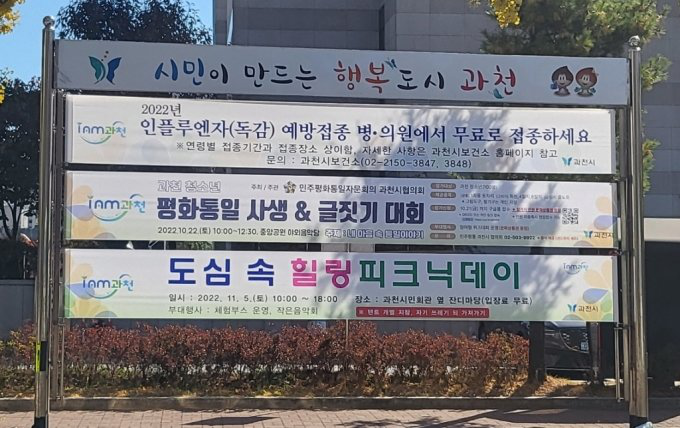

<Detect 이미지>


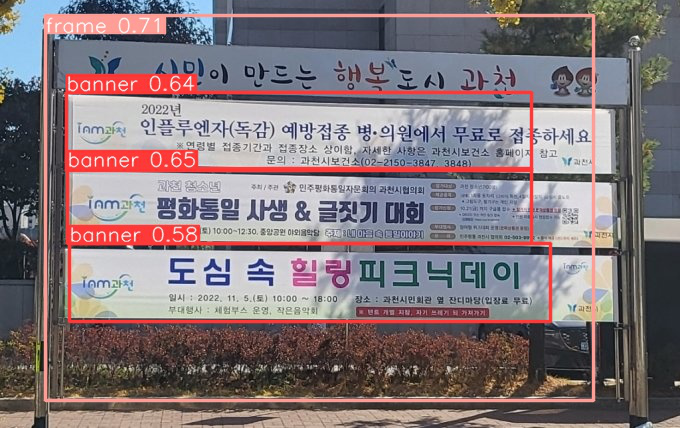

<Crop 이미지들>
클래스명 :  frame
확률 :  0.7058246


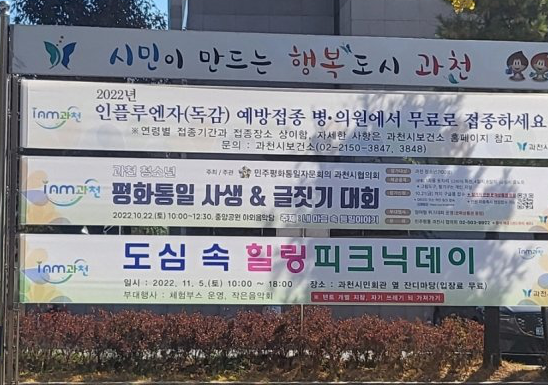

클래스명 :  banner
확률 :  0.6490922


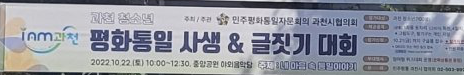

클래스명 :  banner
확률 :  0.6363098


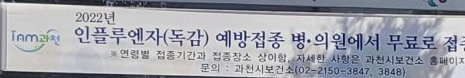

클래스명 :  banner
확률 :  0.58304167


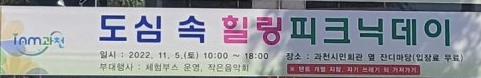

In [230]:
check_object_detection(df_report,1)

#### OCR 결과 확인 

In [227]:
# Crop 이미지들 (이미지마다 갯수 다름)
def check_ocr(df_report,idx):
    n = len(df_report.loc[idx]['Crop_imgs'])
    crop_class_names = df_report.loc[idx]['Crop_classes']
    crop_confidences = df_report.loc[idx]['Crop_conf']
    crop_texts = df_report.loc[idx]['OCR_text'].copy()

    for i in range(n):
        print("클래스명 : ",crop_class_names[i])
        print("확률 : ",crop_confidences[i])
        if crop_class_names[i] == 'frame':
            print("내용 : *frame 입니다.")
        else:
            print("내용 : ",crop_texts[i])
        img = Image.fromarray(np.uint8(df_report.loc[1]['Crop_imgs'][i]))
        display(img)

클래스명 :  frame
확률 :  0.7058246
내용 : *frame 입니다.


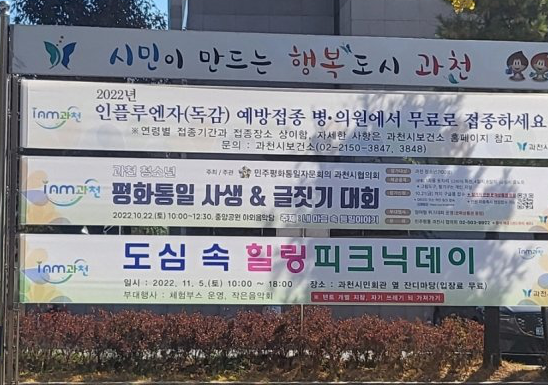

클래스명 :  banner
확률 :  0.6490922
내용 :  ['T0M과천 평화동일 과전 짐소년 사샘 주터/주린 & 민주필화동얻자문 글짓기 대화 협의초', '2022102211000 1고9 조교원 마외닥든']


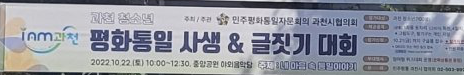

클래스명 :  banner
확률 :  0.6363098
내용 :  ['T0M고천 인플루엔자독감 2022년 면령별 접종기간과 접종소 예방접종 상이항 병의 자세한 원에서 사항은 과천시보건소 384배 무료로 홈메이 접']


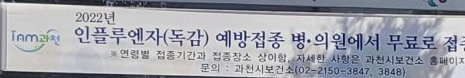

클래스명 :  banner
확률 :  0.58304167
내용 :  ['도심속힐링피크닉데이', 'Tom관천', '엄시:2022115토 구대형사 래협부스 문임 10:00 직은음악회 18:00 징소 과천시민회관 잔디마당엄장로 가까기 부료']


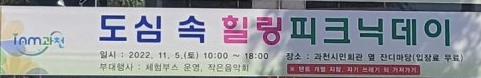

In [228]:
# df_report 와 idx
check_ocr(df_report,1)

##### 로그 저장 디렉토리

In [197]:
# !pip install tree

# 원본 이미지(origin_img)
# detect된 이미지(detect_img)
# crop된 이미지(crop_imgs,'banner','frame')

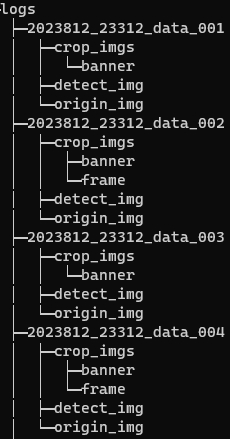